## Лабораторная работа №7 по курсу "Нейроинформатика" на тему "Автоассоциативные сети с узким горлом"

*Целью работы* является исследование свойств автоассоциативных сетей с узким горлом, алгоритмов обучения, а также применение сетей для выполнения линейного и нелинейного анализа главных компонент набора данных.

### Вариант 1
Выполнил студент Шавандрин Фёдор  
Группа М8О-408Б-19

In [1]:
# импортируем библиотеки
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.layers import Layer
from keras import backend as back

import matplotlib.pyplot as plt

В качестве датасета будем использовать CIFAR-10.

In [3]:
train_data, test_data = keras.datasets.cifar10.load_data()

### Обучающая и тестовая выборка

In [8]:
X_train, y_train = train_data
X_test, y_test = test_data

X_train = np.array([X_train[i] for i in range(len(X_train)) if y_train[i] == 1])
X_test = np.array([X_test[i] for i in range(len(X_test)) if y_test[i] == 1])

In [9]:
X_train.shape, X_test.shape

((5000, 32, 32, 3), (1000, 32, 32, 3))

Имеем 5000 изображений размером 32x32 в обучающей выборке и 1000 изображений такого же размера в тестовой выборке.

### Изображения из датасета

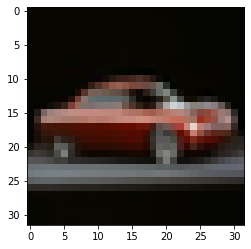

In [11]:
plt.imshow(X_train[20])

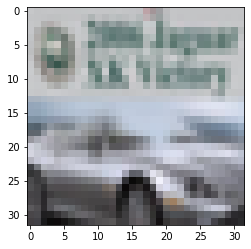

In [12]:
plt.imshow(X_train[22])

Имеем изображения автомобилей.

### Реализация автоэнкодера

Автоэнкодер состоит из двух частей: энкодера, который сжимает исходное изображение, и декодера, который возвращает первоначальный размер изображения. В энкодере и декодере буду использовать 2 линейных слоя, в качестве функций активации - Tanh и Relu. Нормирую значения изображения, приведя их к диапазону $[0, 1]$.

In [25]:
class autoencoder(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.encoder = keras.Sequential([
            keras.layers.Flatten(),
            keras.layers.Dense(32*32*3 / 4, activation='tanh'),
            keras.layers.Dense(32*32*3 / 16, activation='sigmoid'),
        ])
        self.decoder = keras.Sequential([
            keras.layers.Dense(32*32*3 / 4, activation='tanh'),
            keras.layers.Dense(32*32*3, activation='sigmoid'),
            keras.layers.Reshape((32, 32, 3)),
        ])
    
    def call(self, input):
        # нормировка к [0, 1]
        input = input / 255
        encoded_vals = self.encoder(input)
        decoded_vals = self.decoder(encoded_vals)
        return decoded_vals * 255
    
    def change_neuron_value(self, input, index, value):
        # нормировка к [0, 1]
        input = input / 255
        encoded_vals = np.array(self.encoder(input))
        print('True encoded values: ', encoded_vals[:, index])
        encoded_vals[:, index] = value
        decoded_vals = self.decoder(encoded_vals)
        return  decoded_vals * 255

### Обучение модели
В качестве лосса буду использовать MSE, алгоритма обучения - Adam, метрики - mae.

In [26]:
model = autoencoder()

In [27]:
model.compile(
    loss='mse',
    optimizer='Adam',
    metrics='mae',
)

In [28]:
train_info = model.fit(
    X_train, X_train,
    validation_data=(X_test, X_test),
    batch_size=128,
    epochs=500,
    verbose=0,
)

### Графики лосса MSE и MAE

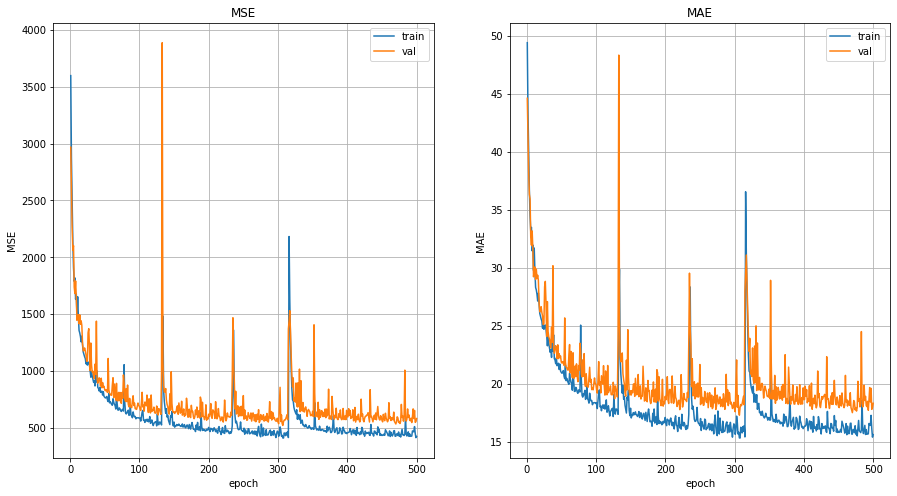

In [29]:
plt.figure(figsize=(15, 8))

plt.subplot(1, 2, 1)
loss_history = train_info.history['loss']
val_loss_history = train_info.history['val_loss']
plt.xlabel('epoch')
plt.ylabel('MSE')
plt.plot(range(1, len(loss_history) + 1), loss_history, label='train')
plt.plot(range(1, len(loss_history) + 1), val_loss_history, label='val')
plt.grid()
plt.legend()
plt.title('MSE')

plt.subplot(1, 2, 2)
mae_history = train_info.history['mae']
val_mae_history = train_info.history['val_mae']
plt.xlabel('epoch')
plt.ylabel('MAE')
plt.plot(range(1, len(mae_history) + 1), mae_history, label='train')
plt.plot(range(1, len(val_mae_history) + 1), val_mae_history, label='val')
plt.grid()
plt.legend()
plt.title('MAE')

plt.show()

### Результат работы автоэнкодера:

In [40]:
def buid_results_plot(original, decoded):
    plt.figure(figsize=(20, 4))

    for i in range(10):
        # display original
        ax = plt.subplot(2, 10, i + 1)
        plt.imshow(original[i])
        plt.title("original")

        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(2, 10, i + 1 + 10)
        plt.imshow(decoded[i])
        plt.title("decoded")

        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()

#### На обучающей выборке

In [31]:
random_train = X_train[np.random.choice(X_train.shape[0], 10)]
random_train_decoded = tf.cast(model(random_train), 'int32')

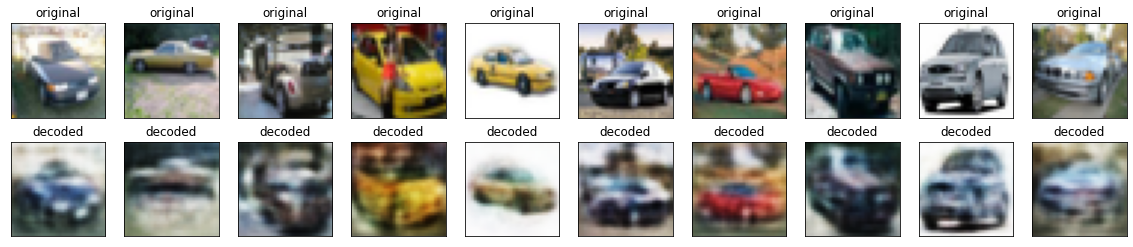

In [41]:
buid_results_plot(random_train, random_train_decoded)

#### На тестовой выборке

In [33]:
random_test = X_test[np.random.choice(X_test.shape[0], 10)]
random_test_decoded = tf.cast(model(random_test), 'int32')

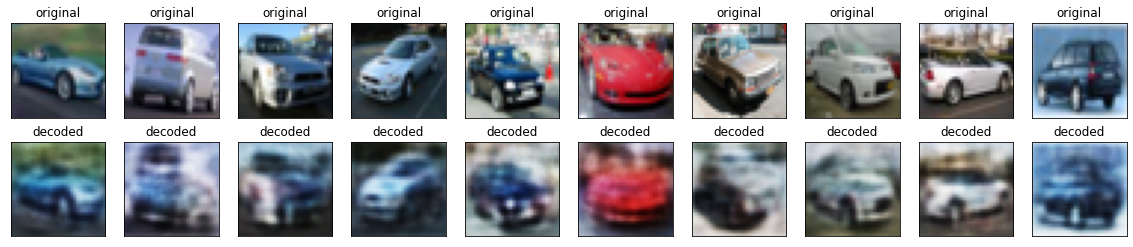

In [42]:
buid_results_plot(random_test, random_test_decoded)

Посмотрим, как изменится результат автоэнкодера при изменении значений в ядре изображений из датасета.

In [36]:
random_test_decoded1 = tf.cast(model.change_neuron_value(random_test, 96, -111), 'int32')
random_test_decoded2 = tf.cast(model.change_neuron_value(random_test, 96, 0), 'int32')
random_test_decoded3 = tf.cast(model.change_neuron_value(random_test, 96, 111), 'int32')

True encoded values:  [0.00090852 0.0023655  0.00037384 0.00161466 0.02013859 0.00122619
 0.09810892 0.00153726 0.002343   0.05362442]
True encoded values:  [0.00090852 0.0023655  0.00037384 0.00161466 0.02013859 0.00122619
 0.09810892 0.00153726 0.002343   0.05362442]
True encoded values:  [0.00090852 0.0023655  0.00037384 0.00161466 0.02013859 0.00122619
 0.09810892 0.00153726 0.002343   0.05362442]


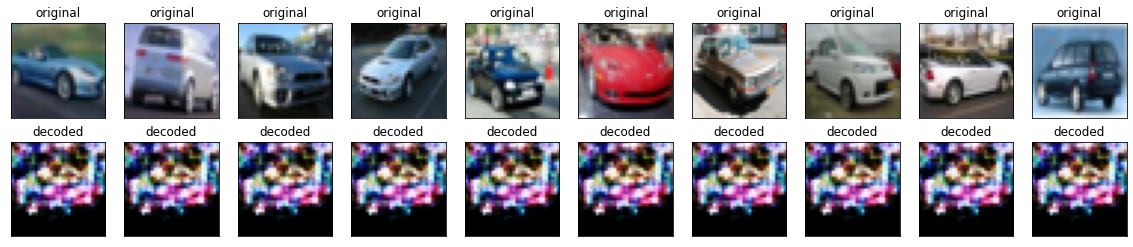

In [43]:
buid_results_plot(random_test, random_test_decoded1)

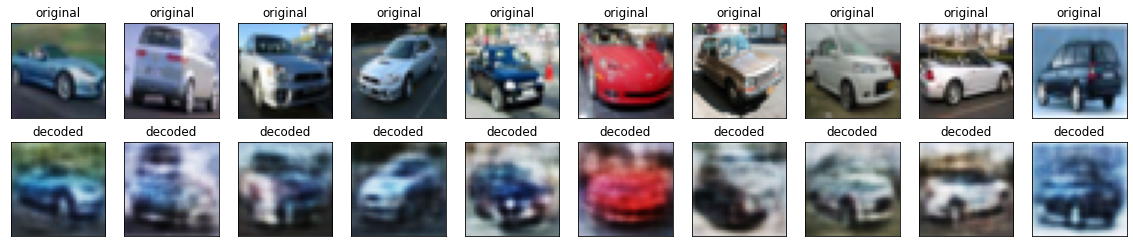

In [44]:
buid_results_plot(random_test, random_test_decoded2)

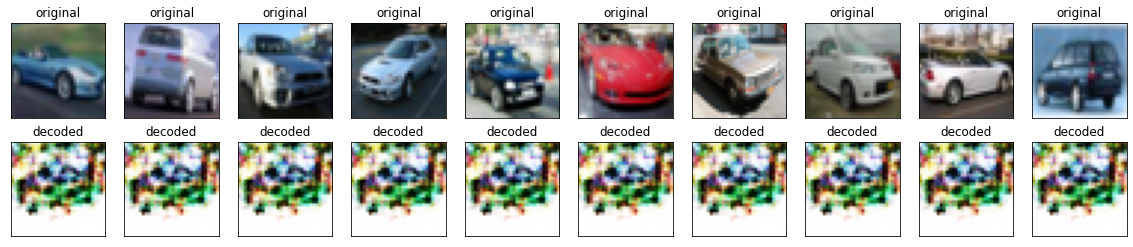

In [45]:
buid_results_plot(random_test, random_test_decoded3)

При значительном изменении значений в ядре изображений автоэнкодер выдаёт одинаковую неразборчивую картинку для всех входных данных.  

Теперь попробуем проделать всё тоже самое, но делая незначительные изменения значений в ядре изображения и изменив позицию, на которой будем делать изменения.

In [50]:
random_test_decoded1_new = tf.cast(model.change_neuron_value(random_test, 48, -1), 'int32')
random_test_decoded2_new = tf.cast(model.change_neuron_value(random_test, 48, 0), 'int32')
random_test_decoded3_new = tf.cast(model.change_neuron_value(random_test, 48, 1), 'int32')

True encoded values:  [0.1555787  0.28166327 0.08461896 0.16923118 0.2842304  0.67018616
 0.25611925 0.15054387 0.1304236  0.17337024]
True encoded values:  [0.1555787  0.28166327 0.08461896 0.16923118 0.2842304  0.67018616
 0.25611925 0.15054387 0.1304236  0.17337024]
True encoded values:  [0.1555787  0.28166327 0.08461896 0.16923118 0.2842304  0.67018616
 0.25611925 0.15054387 0.1304236  0.17337024]


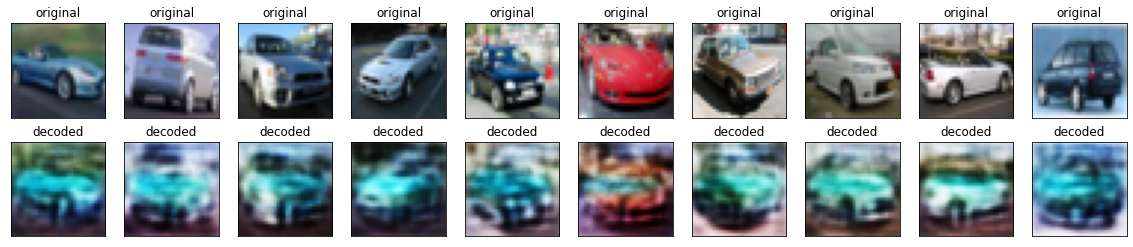

In [51]:
buid_results_plot(random_test, random_test_decoded1_new)

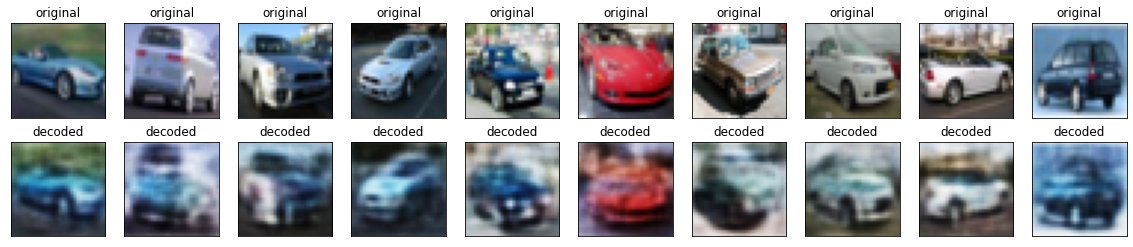

In [52]:
buid_results_plot(random_test, random_test_decoded2_new)

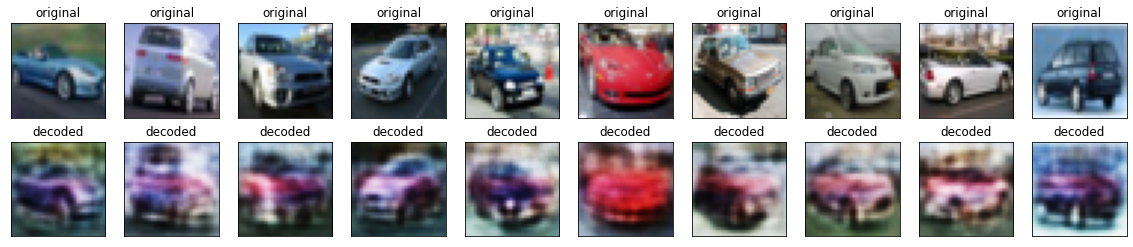

In [53]:
buid_results_plot(random_test, random_test_decoded3_new)

При незначительном изменении значений в ядре входного изображении можно наблюдать преобладанаие определенного цвета автомобиля на изображении. Например, в первом случае, наблюдается преобладание бирюзового цвета, в 3-ем - сине-красноватого цвета.

### Выводы

В ходе данной лабораторной работы я познакомился с таким типом нейронной сети, как автоэнкодер, реализовал свой автоэнкодер для решения задачи восстановления изображения из его сжатого векторного представления. Полученный результат оказался достаточно неплохим, однако автоэнкодер выдавал нечёткие изображения автомобилей.